In [57]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import os
import PIL
import time
import glob
import imageio
from IPython import display

In [58]:
(train_images,train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

(60000, 28, 28)


In [59]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(train_images.shape)

(60000, 28, 28, 1)


In [60]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [61]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [62]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

tf.Tensor(
[[ 1.5236647  -0.62794006  0.34483832 -0.35611525  0.4294116  -2.441613
   1.1309624   1.1509069  -0.01242911  0.58269036  1.2776097  -0.5407227
   1.3355      0.22950505 -0.24850965 -0.06483211 -1.906765    0.17787598
  -0.36106366  1.3364629   0.21387722 -0.5653128   0.3311226  -1.9961764
   0.46998936 -0.16429928 -0.18996772  0.3314246  -0.26518375  2.285187
   0.59754187 -0.059777    0.16844787  0.64459014  1.1967685  -1.1544138
  -0.8387177  -0.45355773  0.1479184   1.4391457   0.839386   -1.1813364
  -1.0844382  -0.9217474   0.8114024   0.5961903  -0.8845361  -0.00431188
   1.0145403   1.3519374   0.58446014  1.9485482   0.32051304 -1.799156
  -0.5329314  -1.0248073   1.1181878   1.1874402  -0.10675398 -0.01091574
   0.05208205 -0.3957413   0.1621548  -1.1591805  -0.5282194  -1.1367897
  -1.6633774  -0.25713044  0.97067416  2.0093515  -0.606381   -0.46050158
   0.36767676 -0.29105142  0.8535812  -1.5298432   0.24278522 -0.35080016
  -1.2531165  -0.9497157   0.19559705 

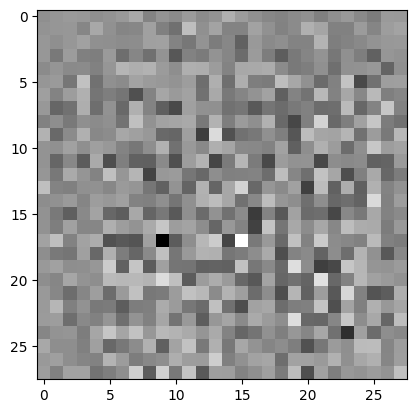

In [63]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
# print(noise)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [64]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [65]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00212494]], shape=(1, 1), dtype=float32)


In [66]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [67]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [68]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [69]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [70]:
generator =  tf.keras.models.load_model('./models/GAN_mnist.keras')
discriminator =  tf.keras.models.load_model('./models/discriminator.keras')

In [71]:
# checkpoint_dir = './MNIST/training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [72]:
EPOCHS = 75
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [73]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [74]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('./images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [75]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

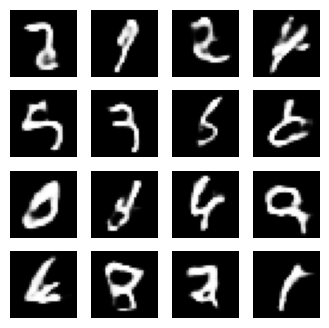

In [76]:
train(train_dataset, EPOCHS)

In [77]:
generator.save('./models/GAN_mnist.keras')
discriminator.save('./models/discriminator.keras')

In [78]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [79]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\marti\AppData\Local\Temp\ipykernel_12420\1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\marti\AppData\Local\Temp\ipykernel_12420\1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



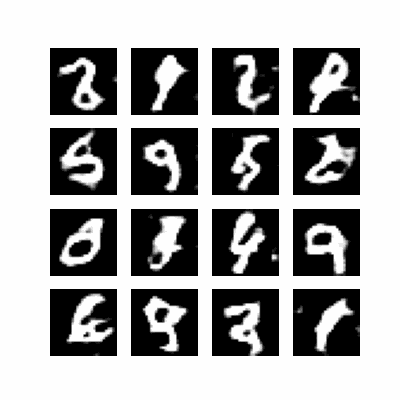

In [80]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)